In [1]:
import numpy as np
from scipy import signal
import seaborn as sns
import scipy.stats as stats
from scipy.ndimage.interpolation import shift
import scipy.interpolate as interpolate
import itertools as it
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from lab.classes.dbclasses import dbMouse
from lab.analysis import behavior_analysis as ba
from lab.misc.auto_helpers import locate
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
%run Helper_Functions.ipynb

In [3]:
with open('Cell_PSTH_Learning_vs_Non_Learning.pkl', 'rb') as f:
    dataBuffer = pickle.load(f)

In [4]:
dataBuffer = dataBuffer[dataBuffer.region != 'CA1']
dataBuffer = dataBuffer.replace(to_replace = 'Bistr', value = 'SOM')
dataBuffer = dataBuffer.replace(to_replace = 'SOM/CB', value = 'SOM')
dataBuffer = dataBuffer.replace(to_replace = 'CA2/CA3', value = 'CA3')

/home/bert/.local/lib/python2.7/site-packages/pandas/core/missing.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [ ]:
summary_data = []
for mousename in ['BV160', 'BV163', 'BV165', 'BV167', 'BV169', 'TG531', 'TG532', 'TG535']:
    for day in np.unique(dataBuffer[dataBuffer.mouse == mousename]['day'].values):
        
        delta_anticip_licks = dataBuffer[dataBuffer.mouse == mousename][dataBuffer.day == day]\
            [dataBuffer.exptType == 'GOL']['Delta_Anticip_Licks'].values[0]
        
        if delta_anticip_licks > 0:
            learning_type = 'Learning'
        else:
            learning_type = 'Non_Learning'
        
        pre_durations = np.concatenate(dataBuffer[dataBuffer.mouse == mousename]\
            [dataBuffer.day == day][dataBuffer.exptType == 'PreGOL']['SWR_Durations'].values)
        post_durations = np.concatenate(dataBuffer[dataBuffer.mouse == mousename]\
            [dataBuffer.day == day][dataBuffer.exptType == 'PostGOL'][dataBuffer.session == 3]\
            ['SWR_Durations'].values)
        
        delta_durations = np.nanmean(post_durations) - np.nanmean(pre_durations)
        
        GOL_start_time = dataBuffer[dataBuffer.mouse == mousename][dataBuffer.day == day]\
            [dataBuffer.exptType == 'GOL']['startTime'].values[0]
        S3_start_time = dataBuffer[dataBuffer.mouse == mousename][dataBuffer.day == day]\
            [dataBuffer.exptType == 'PostGOL'][dataBuffer.session == 3]['startTime'].values[0]
        time_delta = pd.Timedelta(S3_start_time - GOL_start_time).total_seconds()/float(60)
        
        for roiID in np.unique(dataBuffer[dataBuffer.mouse == mousename]\
            [dataBuffer.day == day]['roiID'].values):
            
            if len(dataBuffer[dataBuffer.mouse == mousename]\
                [dataBuffer.day == day][dataBuffer.roiID == roiID]\
                [dataBuffer.exptType == 'PreGOL']['trace']) > 0:
                
                cell_pre_activity = np.nanmean(np.vstack(dataBuffer[dataBuffer.mouse == mousename]\
                    [dataBuffer.day == day][dataBuffer.roiID == roiID]\
                    [dataBuffer.exptType == 'PreGOL']['trace'].values), axis = 0)
            else:
                cell_pre_activity = np.nan
                
            if len(dataBuffer[dataBuffer.mouse == mousename]\
                [dataBuffer.day == day][dataBuffer.roiID == roiID]\
                [dataBuffer.exptType == 'PostGOL'][dataBuffer.session == 3]['trace']) > 0:
                
                cell_post_activity = dataBuffer[dataBuffer.mouse == mousename]\
                    [dataBuffer.day == day][dataBuffer.roiID == roiID]\
                    [dataBuffer.exptType == 'PostGOL'][dataBuffer.session == 3]['trace'].values[0]
            
            else:
                cell_post_activity = np.nan
                
            stype = dataBuffer[dataBuffer.mouse == mousename]\
                [dataBuffer.day == day][dataBuffer.roiID == roiID]['type'].values
            if len(stype) > 0:
                subtype = stype[0]
            else: 
                subtype = np.nan
                
            reg =  dataBuffer[dataBuffer.mouse == mousename]\
                    [dataBuffer.day == day][dataBuffer.roiID == roiID]['region'].values
            if len(reg) > 0:
                region = reg[0]
            else:
                region = np.nan
                
            summary_data.append({'mouse': mousename, 'day': day, 
                'roiID': roiID,
                'Subtype': subtype, 
                'Region': region, 
                'Pre_activity': cell_pre_activity,
                'Post_activity': cell_post_activity,
                'Delta_SWR_Durations': delta_durations,
                'Delta_Anticip_Licks': delta_anticip_licks, 
                'Learning_Type': learning_type,
                'Time_Delta': time_delta})  

summary_data = pd.DataFrame(summary_data)

In [6]:
summary_data = summary_data[summary_data.Time_Delta < 40]

In [7]:
summary_data = summary_data[summary_data.Region == 'CA2']
summary_data = summary_data[summary_data.Learning_Type == 'Learning']

/home/bert/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/bert/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(27, 600) (26, 600)
(21, 600) (19, 600)
(27, 600) (27, 600)
(14, 600) (14, 600)
(18, 600) (16, 600)


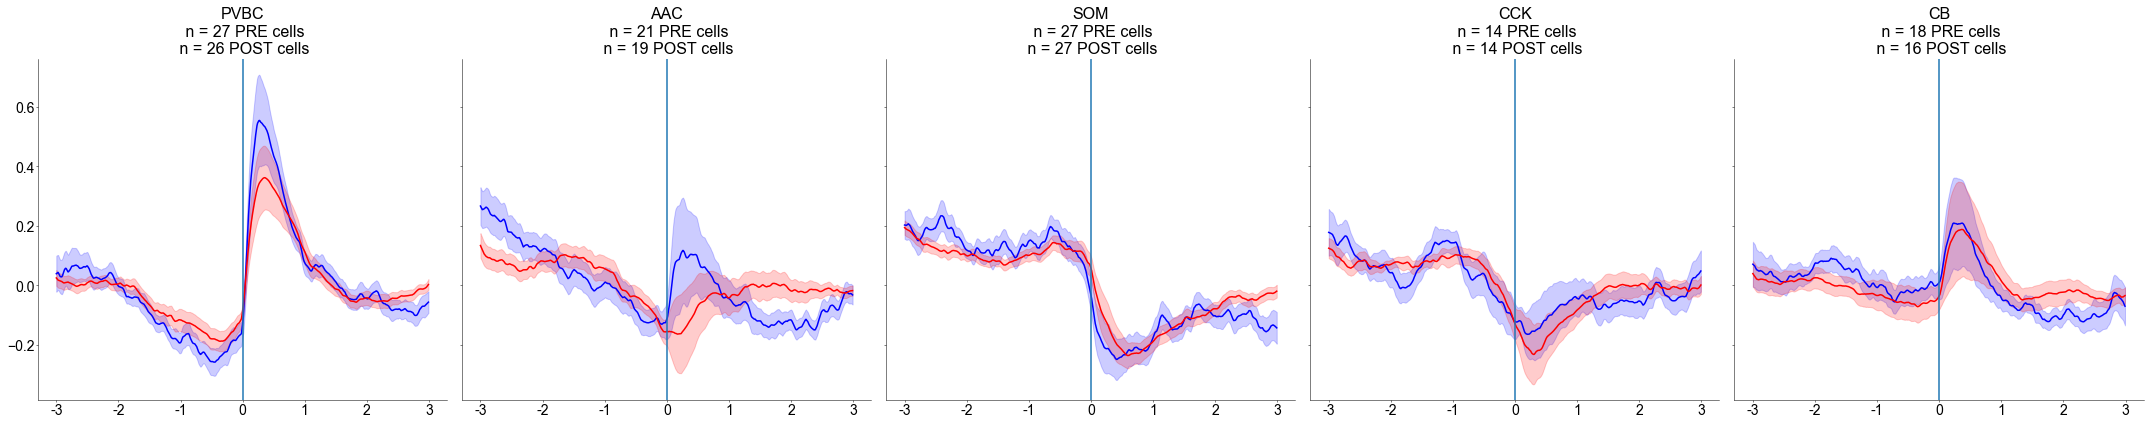

In [8]:
fig, ax = plt.subplots(1, 5, figsize = (30, 6), sharey = True)
subtypes = ['PVBC', 'AAC', 'SOM', 'CCK', 'CB']

for i, subtype in enumerate(subtypes):
    avg_pre_traces = []
    for array in summary_data[summary_data.Subtype == subtype]\
        [~pd.isnull(summary_data.Pre_activity)]['Pre_activity'].values:
        avg_pre_traces.append(array)
    
    resample_pre_traces = []
    for arr in avg_pre_traces:
        resample_pre_traces.append(resample_trace(arr, 600))
    resample_pre_traces = np.asarray(resample_pre_traces)
    
    mean_pre = np.nanmean(resample_pre_traces, axis = 0)
    sem_pre = stats.sem(resample_pre_traces, axis = 0)

    avg_post_traces = []
    for array in summary_data[summary_data.Subtype == subtype]\
        [~pd.isnull(summary_data.Post_activity)]['Post_activity'].values:
        avg_post_traces.append(array)
    
    resample_post_traces = []
    for arr in avg_post_traces:
        resample_post_traces.append(resample_trace(arr, 600))
    resample_post_traces = np.asarray(resample_post_traces)

    print resample_pre_traces.shape, resample_post_traces.shape

    mean_post = np.nanmean(resample_post_traces, axis = 0)
    sem_post = stats.sem(resample_post_traces, axis = 0)
    
    ax[i].plot(mean_pre, color = 'blue')
    ax[i].plot(mean_post, color = 'red')
    ax[i].fill_between(np.arange(0, resample_pre_traces.shape[1]), \
        mean_pre - sem_pre, mean_pre + sem_pre, color = 'blue', alpha = 0.2)
    ax[i].fill_between(np.arange(0, resample_post_traces.shape[1]), \
        mean_post - sem_post, mean_post + sem_post, color = 'red', alpha = 0.2)
    ax[i].set_title(subtype + '\n n = ' + str(resample_pre_traces.shape[0]) + ' PRE cells' + \
        '\n n = ' + str(resample_post_traces.shape[0]) + ' POST cells', \
        fontsize = 16)
    
    ax[i].tick_params(axis = 'y', labelsize = 14)
    ax[i].tick_params(axis = 'x', labelsize = 14)
    ax[i].axvline(x = resample_post_traces.shape[1]/2)
    ax[i].set_xticks([0, 100, 200, 300, 400, 500, 600])
    ax[i].set_xticklabels(['-3', '-2', '-1', '0', '1', '2', '3'])
    #ax[i].set_xticklabels([])
    #ax[i].set_yticklabels([])
    #ax[i].set_xlabel('Time from SWR Onset (s)', fontsize = 16)
    simpleaxis(ax[i])

    #ax[0].set_ylabel('Average Z-Scored DF/F', fontsize = 16)

fig.tight_layout()
plt.savefig('Learning_Days_SWR_PSTHs_CA2_All_Subtypes.svg', format = 'svg', \
            dpi = 1200, transparent = True)

/home/bert/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


[-0.8082495314100353, -0.32923561588010897, -0.7575639447978146, -1.1172492881257825, -0.28889932418601216, -0.5044169654620796, -0.2259804232120653, -0.38949005256887004, -0.4192026326816527, -0.5747865909657546, -0.3238556537098314, -0.31733296848723835, -0.3391044659429632, -0.5201006526593632]
[-0.6221643560117864, -0.17012626396299113, -0.3267588832128355, -0.884970192334956, -0.9683288692889999, -0.48450303843444653, -0.5428629950185271, -0.45982507919493754, -0.6821703023674974, -0.24436353852910986, -0.4502074699745621, -0.31719164259065874, -0.3754481231402708, -0.24369770490878784]
-0.49396200786354083 -0.4837584613550262
0.2398947134865384 0.22942846891248367
WilcoxonResult(statistic=46.0, pvalue=0.683239071626591) 14 14


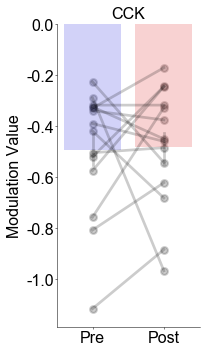

In [12]:
CCK_data = summary_data[summary_data.Subtype == 'CCK']\
            [~pd.isnull(summary_data.Pre_activity)][~pd.isnull(summary_data.Post_activity)]
pre_values = []
post_values = []
for i in range(len(CCK_data)):
    pre_activity = CCK_data.iloc[i].Pre_activity
    post_activity = CCK_data.iloc[i].Post_activity
    pre_trace = resample_trace(pre_activity, 600)
    post_trace = resample_trace(post_activity, 600)
    pre_values.append(np.amin(pre_trace[200:400]) - np.nanmean(pre_trace[0:200]))
    post_values.append(np.amin(post_trace[200:400]) - np.nanmean(post_trace[0:200]))
    
print list(pre_values)
print list(post_values)

print np.nanmean(pre_values), np.nanmean(post_values)
print np.std(pre_values), np.std(post_values)
    
fig, ax = plt.subplots(1, 1, figsize = (3,5))
data = [pre_values, post_values]
data = pd.melt(pd.DataFrame(np.transpose(data)))
data = data.rename(columns = {'variable':'Session_Type', 'value':'Mod_Value'})

cell_number = np.tile(range(len(CCK_data)),2)
data['Cell_Number'] = cell_number

sns.barplot(x = 'Session_Type', y = 'Mod_Value', data = data, ci = 68, alpha = 0.2, \
            palette = ['blue', 'red'], ax = ax)

for i in range(len(np.unique(data.Cell_Number))):
    g = sns.pointplot(x = 'Session_Type', y = 'Mod_Value', data = data[data.Cell_Number == i])
plt.setp(g.collections, color = 'black', alpha=.2) #for the markers
plt.setp(g.lines, color = 'black', alpha=.2)       #for the lines   

ax.set_xlabel('')
ax.set_ylabel('Modulation Value', fontsize = 16)
ax.set_xticklabels(['Pre', 'Post'], fontsize = 16)
ax.set_yticklabels(np.round(ax.get_yticks(), decimals = 2), fontsize = 16)
ax.set_title('CCK', fontsize = 16)

simpleaxis(ax)
print stats.wilcoxon(pre_values, post_values), len(pre_values), len(post_values)

fig.tight_layout()
plt.savefig('CA2_CCK_SWR_PSTH_PRE_POST_Learning_Sessions_Quantification.svg', format = 'svg', \
            dpi = 1200, transparent = True)

/home/bert/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


[2.556394579825534, 0.5011296430802213, 0.3988275337539137, 0.35523772133670856, 1.137231637545855, 1.6304490265950695, 0.35927739695961475, 0.4050396048891064, 0.37864868588539324, 0.9921487479184992, -0.09195916055566347, 0.5347850944893188, 0.6611106201235278, 0.0008236107109154678, 0.5742414238792647, 0.9259410413592559, 1.2302487664306963, 0.3564795993225727, 0.8830818670516813, 1.580786618249828, 2.645504475141336, 1.48112369072692, 0.7813181956566363, 0.282677697986532, 0.48201803184836495, 0.36088936361941987]
[1.0860858599886893, 0.2863421536829427, 0.26948163361065974, 0.027345229524525366, 0.8816481071530614, 0.9147071748740686, 0.07797855929113225, 0.15717123305628258, 0.06370295815172232, 0.701916200296682, -0.02156927195744468, 0.48251366782649463, 1.0289460380200692, 0.29065053565945004, 0.2801230107781326, 0.15512029980063496, 0.8682798512586714, 0.8367224874563277, 0.9683725617736688, 1.284003190241578, 1.13714910640562, 0.9080654385551823, 0.7543382392238178, 0.567184

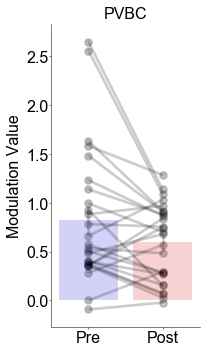

In [15]:
PVBC_data = summary_data[summary_data.Subtype == 'PVBC']\
            [~pd.isnull(summary_data.Pre_activity)][~pd.isnull(summary_data.Post_activity)]
pre_values = []
post_values = []
for i in range(len(PVBC_data)):
    pre_activity = PVBC_data.iloc[i].Pre_activity
    post_activity = PVBC_data.iloc[i].Post_activity
    pre_trace = resample_trace(pre_activity, 600)
    post_trace = resample_trace(post_activity, 600)
    pre_values.append(np.amax(pre_trace[200:400]) - np.nanmean(pre_trace[0:200]))
    post_values.append(np.amax(post_trace[200:400]) - np.nanmean(post_trace[0:200]))
    
print list(pre_values)
print list(post_values)

print np.nanmean(pre_values), np.nanmean(post_values)
print np.std(pre_values), np.std(post_values)
    
fig, ax = plt.subplots(1, 1, figsize = (3,5))
data = [pre_values, post_values]
data = pd.melt(pd.DataFrame(np.transpose(data)))
data = data.rename(columns = {'variable':'Session_Type', 'value':'Mod_Value'})

cell_number = np.tile(range(len(PVBC_data)),2)
data['Cell_Number'] = cell_number

sns.barplot(x = 'Session_Type', y = 'Mod_Value', data = data, ci = 68, alpha = 0.2, \
            palette = ['blue', 'red'], ax = ax)

for i in range(len(np.unique(data.Cell_Number))):
    g = sns.pointplot(x = 'Session_Type', y = 'Mod_Value', data = data[data.Cell_Number == i])
    
plt.setp(g.collections, color = 'black', alpha=.2) #for the markers
plt.setp(g.lines, color = 'black', alpha=.2)       #for the lines   
ax.set_xlabel('')
ax.set_ylabel('Modulation Value', fontsize = 16)
ax.set_xticklabels(['Pre', 'Post'], fontsize = 16)
ax.set_yticklabels(np.round(ax.get_yticks(), decimals = 2), fontsize = 16)
ax.set_title('PVBC', fontsize = 16)

simpleaxis(ax)
print stats.wilcoxon(pre_values, post_values), len(pre_values), len(post_values)

fig.tight_layout()
plt.savefig('CA2_PVBC_SWR_PSTH_PRE_POST_Learning_Sessions_Quantification.svg', \
            format = 'svg', dpi = 1200, transparent = True)